Searching for a query in embedding form (for example sentence transformers) against an embeddding database is an O(N) operation for each query

So if you have M queries and N is the size of your corpus embedding, we are talking about an O(M * N) operation which is very expensive

## Example

1) Given an image of a building, in your corpus, find all other images of this building
This requires you to construct a numeric representation (embedding) of all images in your corpus, and find the vectors which are closest to your query image (the building image)

Closest can be defined as vectors which are similar by euclidean distance

2) Maximum inner product search

Let's say you have a query (can be a user in a recommendation system context ) which can be represented as an embedding of dimension N. If we want to find out which items the user is likely to buy, (assuming the user-item embedding has been trained jointly) , you want to find out which items in our corpus the query has the largest dot product with

For both these above problems (given a query, find vectors in database which are closest from a euclidean distance standpoint; and given a query, find vectors in database which have the highest dot product), we need to do this at scale (since your database can have billions of entries)

Faster algorithms include ANNOY from Spotify, FAISS from facebook, hnswlib
The other sections in this folder will talk about those implementations and how they speed up this process

## Steps in vector search

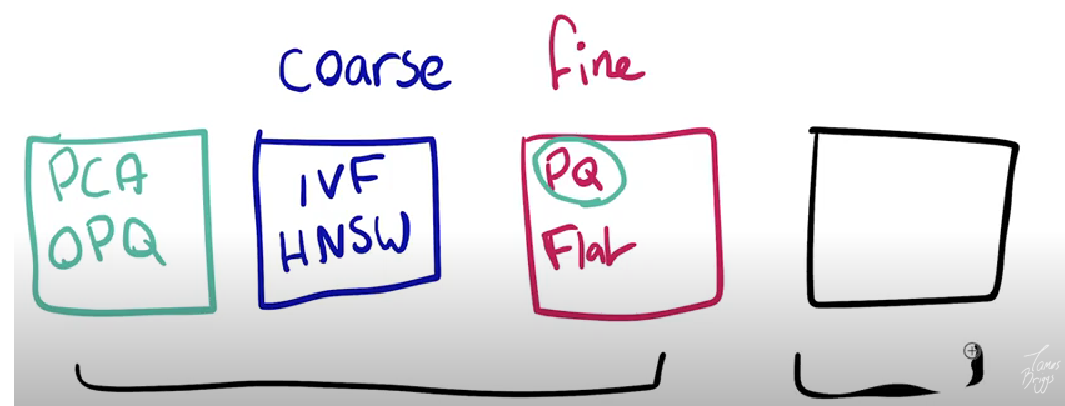

Step 0 - (Optional) preprocessing Vector transform - can be PCA for dimensionality reduction or OPQ (Optimized product quantization)


Step 1 - Coarse quantizer - IVF or HNSW 

Step 2 - Fine quantizer  - PQ (Product Quantization), maybe even flat vectors

Step 3 (Optional) Postprocessing - Reranking of top K hits

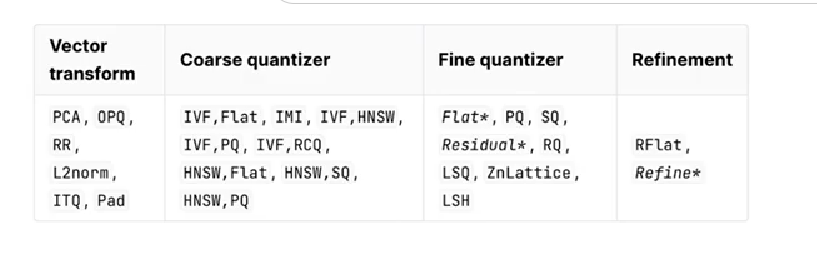


One sample workflow. Take set of incoming vectors

Step 0 - transform them using OPQ - Transform/rotate

Step 1 - Assign transformed vectors to partitions from IVF index

Step 2 - Use product quantization to compress

Step 3 - further refinement


Combining coare + fine is called composite indexing


Example of IVF-PQ

1) Taking incoming vector, do IVF, assign to partitions
2) Separately, also do PQ on it, and assign PQ representation of vector to IVF cell (which will not be in same geometric space, but that's ok)

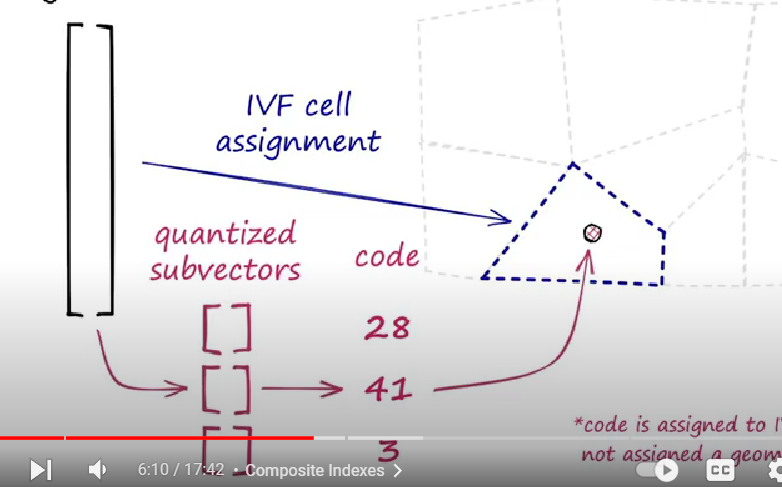


3)

## Comparison between different strategies

https://thesequence.substack.com/p/guest-post-choosing-the-right-vector


1) 100% recall: This one is fairly simple - use FLAT search if you need 100% accuracy. All efficient data structures for vector search perform _approximate_ nearest neighbor search, meaning that there's going to be a loss of recall once the index size hits a certain threshold.


2) index_size < 10MB: If your total index size is tiny (fewer than 5k 512-dimensional `float32` vectors), just use FLAT search. The overhead associated with index building, maintenance, and querying is simply not worth it for a tiny dataset.

3) 10MB < index_size < 2GB: If your total index size is small (fewer than 100k 512-dimensional float32 vectors), my recommendation is to go with a standard inverted-file index (e.g. IVF). An inverted-file index can reduce the search scope by around an order of magnitude while still maintaining fairly high recall.


4) 2GB < index_size < 20GB: Once you reach a mid-size index (fewer than 10M 512-dimensional float32 vectors), you'll want to start considering other PQ and HNSW index types. Both will give you reasonable query speed and throughput, but PQ allows you to use significantly less memory at the expense of low recall, while HNSW often gives you 95%+ recall at the expense of high memory usage - around 1.5x the total size of your index. For dataset sizes in this range, composite IVF indexes (IVF_SQ, IVF_PQ) can also work well, but I would use them only if you have limited compute resources.


5) 20GB < index_size < 200GB: For large datasets (fewer than 100M 512-dimensional float32 vectors), I recommend the use of _composite indexes_: IVF_PQ for memory-constrained applications and HNSW_SQ for applications that require high recall. A composite index is an indexing technique combining multiple vector search strategies into a single index. This technique effectively combines the best of both indexes; HNSW_SQ, for example, retains most of HNSW's base query speed and throughput but with a significantly reduced index size. We won't dive too deep into composite indexes here, but FAISS's documentation provides a great overview for those interested.

## References

https://levelup.gitconnected.com/vector-database-the-secret-behind-large-language-models-capabilities-7d4f6b714d16

https://www.youtube.com/watch?v=GEhmmcx1lvM&t=15s - Nice video

https://thesequence.substack.com/p/guest-post-choosing-the-right-vector - Comparison on when to choose which strategy